In [14]:
from cocoPoolDataset import CocoDetection
from transformers import DetrImageProcessor
import supervision as sv

In [15]:
import os

print("Train, Validation, Test")
len(os.listdir("dataset-DETR\\train\\")), len(os.listdir("dataset-DETR\\valid\\")), len(os.listdir("dataset-DETR\\test\\"))

Train, Validation, Test


(4968, 1407, 725)

In [16]:
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [19]:
TRAIN_DATASET = CocoDetection(
    image_directory_path="dataset-DETR\\train",
    image_processor=image_processor,
    train=True
)

VAL_DATASET = CocoDetection(
    image_directory_path="dataset-DETR\\valid",
    image_processor=image_processor,
    train=False
)

TEST_DATASET = CocoDetection(
    image_directory_path="dataset-DETR\\test",
    image_processor=image_processor,
    train=False
)

print(f"Train dataset size: {len(TRAIN_DATASET)}")
print(f"Validation dataset size: {len(VAL_DATASET)}")
print(f"Test dataset size: {len(TEST_DATASET)}")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Train dataset size: 1406
Validation dataset size: 4967
Test dataset size: 4967


Image #2751
annotations:  [{'id': 3942, 'image_id': 2751, 'category_id': 1, 'bbox': [199.55, 19.04, 24.44999999999999, 44.44], 'area': 1086.5579999999995}, {'id': 3943, 'image_id': 2751, 'category_id': 1, 'bbox': [183.88, 0.0, 13.319999999999993, 1.02], 'area': 13.586399999999994}]


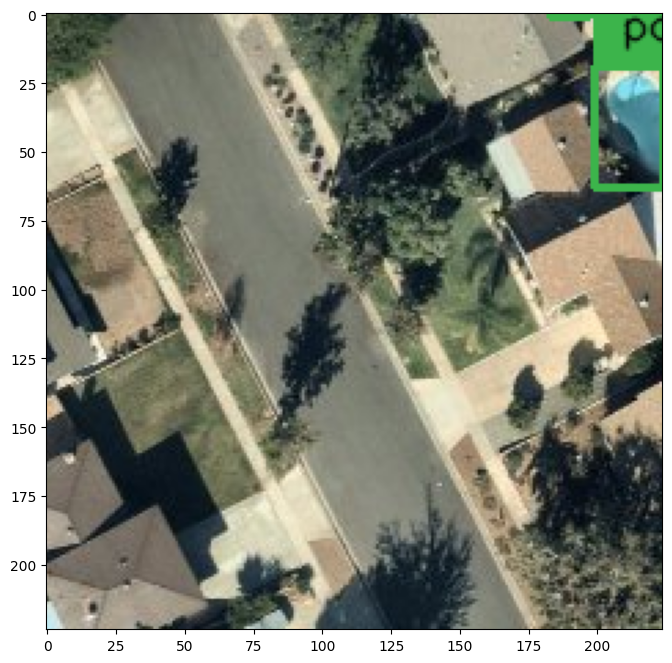

In [5]:
# Visualize if dataset is loaded correctly

import random
import cv2
import numpy as np

# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

print("annotations: " , annotations)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image, (8, 8))

In [6]:
# Prepare data

from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        "pixel_values": encoding["pixel_values"],
        "pixel_mask": encoding["pixel_mask"],
        "labels": labels
    }


train_loader = DataLoader(dataset=TRAIN_DATASET, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset=VAL_DATASET, batch_size=4, collate_fn=collate_fn)
test_loader = DataLoader(dataset=TEST_DATASET, batch_size=4, collate_fn=collate_fn)

# Train the model using PyTorch Lightning

The DETR model is loaded using the Hugging Face Transformers library.

In [7]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch 

class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",
            num_labels = len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [8]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(train_loader))
outputs = model(pixel_values=batch["pixel_values"], pixel_mask=batch["pixel_mask"])

c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\romul\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initi

In [13]:
from pytorch_lightning import Trainer

MAX_EPOCHS = 5
trainer = Trainer(max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\romul\Desktop\FACULDADE 23-24\2º Semestre\Aprendizagem Profunda\Final Project\Deep-Learning-Project\lightning_logs

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.007   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:03<00:03,  0.26it/s]

c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   4%|▍         | 51/1242 [07:04<2:45:06,  0.12it/s, v_num=0]

c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
MODEL_PATH = "detr-coco"
model.model.save_pretrained(MODEL_PATH)

# # loading model
# model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
# model.to(device)